In [1]:
!pip install ucimlrepo

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
forest_fires = fetch_ucirepo(id=162) 
  
# data (as pandas dataframes) 
X = forest_fires.data.features 
y = forest_fires.data.targets 
  
# metadata 
print(forest_fires.metadata) 
  
# variable information 
print(forest_fires.variables) 

{'uci_id': 162, 'name': 'Forest Fires', 'repository_url': 'https://archive.ics.uci.edu/dataset/162/forest+fires', 'data_url': 'https://archive.ics.uci.edu/static/public/162/data.csv', 'abstract': 'This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data (see details at: http://www.dsi.uminho.pt/~pcortez/forestfires).', 'area': 'Climate and Environment', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 517, 'num_features': 12, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['area'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5D88D', 'creators': ['Paulo Cortez', 'Anbal Morais'], 'intro_paper': {'ID': 368, 'type': 'NATIVE', 'title': 'A data mining approach to predict forest fires using meteorological da

In [2]:
import os
import numpy as np
import pandas as pd
from ipywidgets import interact, fixed, widgets
from tqdm import tqdm
import matplotlib.pyplot as plt

# visulisation function
from functions.visualisations import (
    histogram_trace, plot_y_timeseries, 
    plot_ycorr_scatter, boxplot_weights, plot_confusion_matrix,
    plot_linear_data
)

In [3]:
from types import MethodType
np.random.seed(2023)

In [39]:
file_path = 'C:/Users/CELESTE/OneDrive/Desktop/polimi/magistrale/Computational statistics/comp project/forestfires.csv'
fires = pd.read_csv(file_path)

In [40]:
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [41]:
fires.shape

(517, 13)

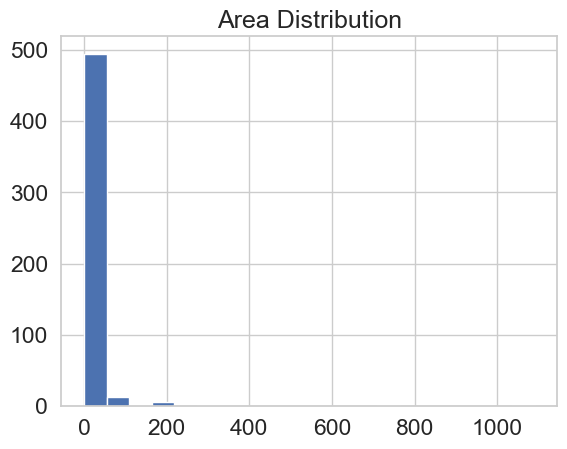

In [42]:
plt.hist(fires.area, bins=20)
plt.title('Area Distribution')
plt.show()

Even after a log-transformation it is still too skewed around zero, we will transform the target variable in a categorical one then.

In [43]:
fires['area_cat'] = pd.cut(fires['area'], bins=[0,5, 10, 50, 100, 1100], include_lowest=True, 
                                 labels=['0-5', '5-10', '10-50', '50-100', '>100'])
fires.area_cat.value_counts() 

area_cat
0-5       366
10-50      71
5-10       56
50-100     13
>100       11
Name: count, dtype: int64

In [44]:
fires = fires.drop(columns=['area'])
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_cat
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0-5
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0-5
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0-5
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0-5
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0-5


In [45]:
print(fires.month.value_counts())
months_to_remove = ['nov','jan','may']
fires = fires.drop(fires[fires.month.isin(months_to_remove)].index ,axis=0)
fires.month.value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64


month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
Name: count, dtype: int64

In [46]:
# Scale numerical features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
numerical_cols = ['X', 'Y', 'FFMC','DC','DMC','ISI','temp','RH','wind','rain']
scaler = StandardScaler()
fires[numerical_cols] = scaler.fit_transform(fires[numerical_cols])

fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_cat
0,1.004398,0.566345,mar,fri,-1.033763,-1.347849,-1.870554,-0.879667,-1.874335,0.435353,1.493665,-0.073627,0-5
1,1.004398,-0.245892,oct,tue,-0.052735,-1.203047,0.476707,-0.526386,-0.169263,-0.692306,-1.742337,-0.073627,0-5
2,1.004398,-0.245892,oct,sat,-0.052735,-1.072410,0.549395,-0.526386,-0.760819,-0.692306,-1.519164,-0.073627,0-5
3,1.435817,1.378582,mar,fri,0.192521,-1.236100,-1.939159,-0.018544,-1.856936,3.317147,-0.012750,0.599535,0-5
4,1.435817,1.378582,mar,sun,-0.342584,-0.952791,-1.838293,0.113937,-1.317577,3.442442,-1.240198,-0.073627,0-5


In [47]:
from sklearn.model_selection import train_test_split

X = fires.drop(columns=['area_cat'])
y = fires['area_cat']

# Dividere in train e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Categorical variables 
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
oe.fit(X_train[['month', 'day']])  
X_train[['month', 'day']] = oe.transform(X_train[['month','day']])
X_test[['month','day']] = oe.transform(X_test[['month','day']])
y_train = pd.get_dummies(y_train, columns=['area_cat'])
y_test = pd.get_dummies(y_test, columns=['area_cat'])

In [49]:
print(X_train.head(), y_train.head())

            X         Y  month  day      FFMC       DMC        DC       ISI  \
322  0.572979  0.566345    8.0  4.0  0.437778  0.112764  0.943872 -0.349745   
331  1.004398 -0.245892    8.0  2.0  0.081041  0.197756  0.992059 -0.128944   
174 -1.584118 -0.245892    1.0  2.0 -0.141920 -0.235076  0.293353 -0.040624   
273 -0.289860  1.378582    2.0  3.0 -1.435092 -1.332110 -0.812081 -0.504306   
495  0.572979  1.378582    1.0  1.0  1.195845  1.002038  0.446896  1.703703   

         temp        RH      wind      rain  
322 -0.378048 -1.005545 -0.012750 -0.073627  
331  0.439691 -1.005545  0.266216 -0.073627  
174 -0.830414  0.560648 -1.240198 -0.073627  
273 -2.465890  0.811239  2.497941 -0.073627  
495  0.857259 -0.128477 -1.017026 -0.073627          0-5   5-10  10-50  50-100   >100
322   True  False  False   False  False
331  False  False   True   False  False
174   True  False  False   False  False
273  False   True  False   False  False
495   True  False  False   False  False


In [50]:
# Ottieni il vettore di indici (targets)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Bayesian linear model for classification of the variable "Area"

In [51]:
class LinearModel:
    '''
    Simple linear model with a single output (y) given the covariates x_1...x_M of the form:
    y = w_1 * x_1 + ... + w_M * x_M + b
    where M = number of features, w are the weights, and b is the bias.
    '''
    # Initialise values of model parameters
    def __init__(self, layer_sizes):
        self.w = None
        self.b = None        
        self.input_num = layer_sizes[0]
        self.output_num = layer_sizes[-1] 
        self.n_params = (self.input_num * self.output_num) + self.output_num

    # Function to take in data and parameter sample and return the prediction
    def evaluate_proposal(self, data, theta):
        '''
        Encode the proposed parameters and then use the model to predict
        Input:
            data: (N x M) array of data
            theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
        '''
        self.encode(theta)  # method to encode w and b
        prediction = self.predict(data) # predict and return
        
        probs = self.softmax(prediction)
        prediction = np.argmax(probs, axis=1)
        #print(f"Prediction fin Shape: {prediction.shape}, Content: {prediction}")
        return prediction, probs

    # Linear model prediction
    def predict(self, x_in):
        y_out = x_in.dot(self.w) + self.b 
        #print(f"Prediction Shape: {y_out.shape}, Content: {y_out}")
        return y_out
    
    # Helper function to split the parameter vector into w and band store in the model
    def encode(self, theta):
        self.w =  np.reshape(theta[:-self.output_num], (-1, self.output_num))
        self.b = theta[-self.output_num:] 

    # helper function for softmax
    def softmax(self, x):
        '''
        Implentation of the softmax function
        '''
        x = np.asarray(x)
        # Imposta le opzioni di stampa per visualizzare in notazione scientifica
        np.set_printoptions(precision=8, formatter={'all': lambda x: '{:e}'.format(x)})
        #print(f"Tipo di x: {type(x)}, Contenuto di x: {x}")
        prob = np.exp(x) / np.sum(np.exp(x))
        return prob        

In [52]:
# Define the likelihood function
def likelihood_function(self, theta, test=False):
    '''
    Calculate the likelihood of the data given the parameters
    Input:
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
    Output:
        log_likelihood: log likelihood of the data given the parameters
        model_prediction: prediction of the model given the parameters
        accuracy: accuracy of the model given the parameters
    '''
    # first make a prediction with parameters theta
    if test:
        x_data = self.x_test
        y_data = self.y_test
    else:
        x_data = self.x_data
        y_data = self.y_data
    model_prediction, probs = self.model.evaluate_proposal(x_data, theta)
    model_simulation = model_prediction # tausq unused for classification
    accuracy = self.accuracy(model_prediction, y_data) #Accuracy error metric 
    # now calculate the log likelihood
    log_likelihood = 0
    for ii in np.arange(x_data.shape[0]):
        for jj in np.arange(self.model.output_num):
            if y_data[ii] == jj:
                log_likelihood += np.log(probs[ii,jj])    
    return [log_likelihood, model_prediction, model_simulation, accuracy] 

# Define the prior
def prior(self, sigma_squared, theta): 
    '''
    Calculate the prior of the parameters
    Input:
        sigma_squared: variance of normal prior for theta
        theta: (M + 1) vector of parameters. The last element of theta consitutes the bias term (giving M + 1 elements)
    Output:
        log_prior: log prior
    '''
    n_params = self.theta_size # number of parameters in model
    part1 = -1 * (n_params / 2) * np.log(sigma_squared)
    part2 = 1 / (2 * sigma_squared) * (sum(np.square(theta)))
    log_prior = part1 - part2
    return log_prior

In [53]:
# MCMC sampler
def sampler(self):
    '''
    Run the sampler for a defined linear model
    '''
    ## Define empty arrays to store the sampled posterior values
    # posterior of all weights and bias over all samples
    pos_theta = np.ones((self.n_samples, self.theta_size)) 

    # record output f(x) over all samples
    pred_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record simulated values f(x) + error over all samples 
    sim_y = np.zeros((self.n_samples, self.x_data.shape[0]))
    # record the accuracy of each sample
    accuracy_data = np.zeros(self.n_samples)
    # now for test
    test_pred_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_sim_y = np.ones((self.n_samples, self.x_test.shape[0]))
    test_accuracy_data = np.zeros(self.n_samples)

    ## Initialisation
    # initialise theta - the model parameters
    theta = np.random.randn(self.theta_size)
    # make initial prediction
    pred_y[0,], _ = self.model.evaluate_proposal(self.x_data, theta)

    # calculate the prior
    prior_val = self.prior(self.sigma_squared, theta)
    # calculate the likelihood considering observations
    [likelihood, pred_y[0,], sim_y[0,], accuracy_data[0]] = self.likelihood_function(theta)

    n_accept = 0  
    ## Run the MCMC sample for n_samples
    for ii in np.arange(1,self.n_samples):
        # Sample new values for theta using a Gaussian random walk
        theta_proposal = theta + np.random.normal(0, self.step_theta, self.theta_size)

        # calculate the prior
        prior_proposal = self.prior(
            self.sigma_squared, theta_proposal
        )
        # calculate the likelihood considering observations
        [likelihood_proposal, pred_y[ii,], sim_y[ii,], accuracy_data[ii]] = self.likelihood_function(theta_proposal)

         # calculate the test likelihood
        [_, test_pred_y[ii,], test_sim_y[ii,], test_accuracy_data[ii]] = self.likelihood_function(
            theta_proposal, test=True
        )

        # Noting that likelihood_function and prior return log likelihoods,
        # we can use log laws to calculate the acceptance probability
        diff_likelihood = likelihood_proposal - likelihood
        diff_prior = prior_proposal - prior_val

        mh_prob = min(1, np.exp(diff_likelihood + diff_prior))

        # sample to accept or reject the proposal according to the acceptance probability
        u = np.random.uniform(0, 1)
        if u < mh_prob:
            # accept and update the values
            n_accept += 1
            likelihood = likelihood_proposal
            prior_val = prior_proposal
            theta = theta_proposal
            # store to make up the posterior
            pos_theta[ii,] = theta_proposal
        else:
            # reject move and store the old values
            pos_theta[ii,] = pos_theta[ii-1,]

    # calculate the acceptance rate as a check
    accept_rate = (n_accept / self.n_samples) * 100
    print('{:.3f}% were accepted'.format(accept_rate))

    # store the posterior (samples after burn in) in a pandas dataframe and return
    self.pos_theta = pos_theta[self.n_burnin:, ]
    self.accuracy_data = accuracy_data[self.n_burnin:]

    # split theta into w and b
    results_dict = {'w{}'.format(_): self.pos_theta[:, _].squeeze() for _ in range(self.theta_size-1)}
    results_dict['b'] = self.pos_theta[:, -1].squeeze()
    results_dict['accuracy'] = self.accuracy_data.squeeze()

    # return the predictions
    pred_dict = {}
    pred_dict['train_pred'] = pred_y[self.n_burnin:,:]
    pred_dict['train_sim'] = sim_y[self.n_burnin:,:]
    pred_dict['test_pred'] = test_pred_y[self.n_burnin:,:]
    pred_dict['test_sim'] = test_sim_y[self.n_burnin:,:]

    results_df = pd.DataFrame.from_dict(
        results_dict
    )
    return results_df, pred_dict

In [54]:
class MCMC:
    def __init__(self, model, n_samples, n_burnin, x_data, y_data, x_test, y_test):
        self.n_samples = n_samples # number of MCMC samples
        self.n_burnin = n_burnin # number of burn-in samples
        self.x_data = x_data # (N x M)
        self.y_data = y_data # (N x 1)
        self.x_test = x_test # (Nt x num_features)
        self.y_test = y_test # (Nt x 1)

        # MCMC parameters - defines the variance term in our Gaussian random walk
        self.step_theta = 0.02;  
        
        # model hyperparameters
        # considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
        self.sigma_squared = 5

        # initisalise the linear model class
        self.model = model
        self.theta_size = self.model.n_params # weights for each feature and a bias term (M+1)

        # store output
        self.pos_theta = None
        self.accuracy_data = None

        # functions defined above - this is poor practice, but done for readability 
        # and clarity
        self.likelihood_function = MethodType(likelihood_function, self)
        self.prior = MethodType(prior, self)
        self.sampler = MethodType(sampler, self)

    # Additional error metric
    @staticmethod
    def accuracy(predictions, targets):
        '''
        Additional error metric - accuracy
        '''
        """
        ntrain=targets.shape[0]
        classes=targets.shape[1] 
        one_hot_matrix = np.zeros((ntrain, classes))
        # Impostiamo 1 nella colonna corrispondente a ciascun indice in prediction
        one_hot_matrix[np.arange(ntrain), predictions] = 1
        predictions = one_hot_matrix
        """
        # Ottieni il vettore di indici (targets): già fatto in y_test e y_train 
        #targets = np.argmax(targets, axis=1)
        
        count = (predictions == targets).sum()
        return 100 * (count / predictions.shape[0])

In [55]:
print(X_train.shape, X_test.shape)

(409, 12) (103, 12)


In [56]:
## MCMC Settings and Setup
n_samples = 25000 # number of samples to draw from the posterior
burn_in = int(n_samples* 0.25) # number of samples to discard before recording draws from the posterior

x_data = X_train
y_data = y_train
x_test = X_test
y_test = y_test

layer_sizes = [x_data.shape[1], 5] #area_cat has 5 classes # [26,5] 
data_case = 'classification'

x_data = np.asarray(x_data)  # Conversione in array NumPy
y_data = np.asarray(y_data) 
x_test = np.asarray(x_test) 
y_test = np.asarray(y_test)

# Initialise the MCMC class
lm = LinearModel(layer_sizes=layer_sizes)
mcmc = MCMC(lm, n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results, pred = mcmc.sampler()

27.696% were accepted


In [57]:
# gather the predicitons into useful variables
pred_y = pred['train_pred']
sim_y = pred['train_sim']
pred_y_test = pred['test_pred']
sim_y_test = pred['test_sim']

In [58]:
# Print the train/test accuracy
trainacc = np.array([mcmc.accuracy(pred_y[_,:], y_data) for _ in np.arange(pred_y.shape[0])])
testacc = np.array([mcmc.accuracy(pred_y_test[_,:], y_test) for _ in np.arange(pred_y_test.shape[0])])

print('Train accuracy: {:.3f}% ({:.3f})'.format(trainacc.mean(), trainacc.std()))
print('Test accuracy: {:.3f}% ({:.3f})'.format(testacc.mean(), testacc.std()))

Train accuracy: 69.107% (0.713)
Test accuracy: 73.167% (1.735)


In [59]:
pred_y_test.shape

(18750, 103)

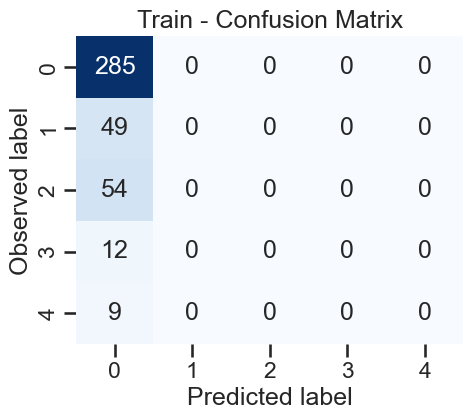

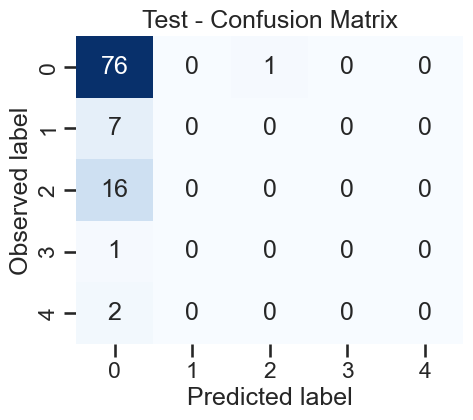

In [60]:
"""
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test,  np.median(pred_y_test, axis=0))
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
# Crea il display della confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plotta la confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

"""
plot_confusion_matrix(y_data, pred_y, title='Train - Confusion Matrix')
plot_confusion_matrix(y_test, pred_y_test, title='Test - Confusion Matrix')


In [61]:
def plot_hist(results, param_name):
    posterior_mean = results[param_name].mean()
    print('{:.3f} mean value of posterior'.format(posterior_mean))
    histogram_trace(results[param_name].values)

# use ipywidgets to get a "gui" dropdown to view all the parameters
interact(
    plot_hist, 
    results=fixed(results), 
    param_name=widgets.Dropdown(
        options=results.columns,
        value='w0',
        description='Parameter:',
    )
)
None

interactive(children=(Dropdown(description='Parameter:', options=('w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w…

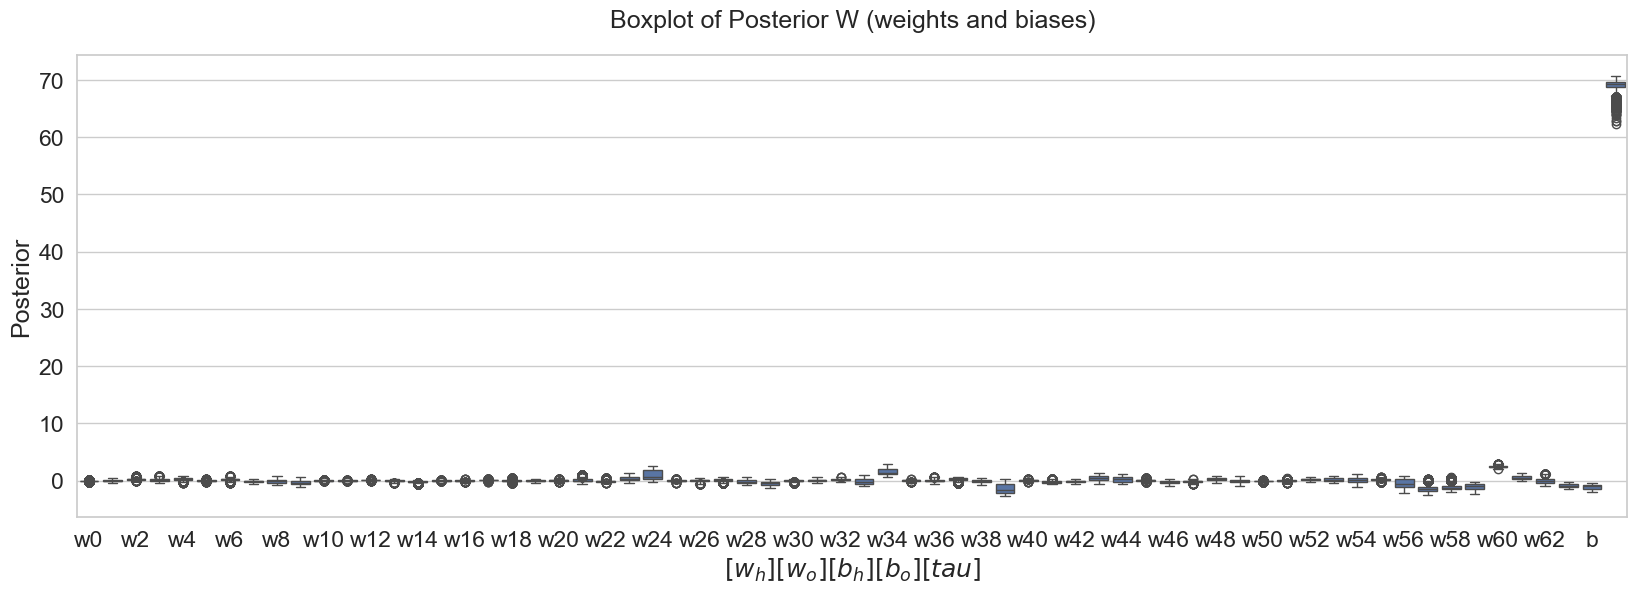

In [62]:
# Visualise all the network weights
boxplot_weights(results,width=20)

In [63]:
import arviz as az
# Sample a second chain as more than one chain is required to generate the Rhat diagnostic
# Run second chain using a different seed
np.random.seed(2)
# setup second chain
mcmc_chain2 = MCMC(lm, n_samples, burn_in, x_data, y_data, x_test, y_test)
# Run the sampler
results_chain2, _ = mcmc_chain2.sampler()

# Now combine these two chains by stacking and convert to arviz dataset
# To convert to arviz, convert the pandas dataframe of samples into a dictionary of lists, stack and ingest into arviz
res_dict = results.to_dict(orient='list')
res_dict_chain2 = results_chain2.to_dict(orient='list')
# stack the chains looping through each parameter
az_results = az.from_dict({par: np.vstack([res_dict[par], res_dict_chain2[par]]) for par in res_dict})

# now we can use arviz to obtain summary statistics with Rhat ("r_hat") for each parameter.
az.summary(az_results)

27.160% were accepted


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
accuracy,69.106,0.691,67.971,70.171,0.037,0.026,306.0,1068.0,1.00
b,-1.900,0.888,-3.128,-0.405,0.589,0.486,3.0,21.0,1.93
w0,-0.052,0.071,-0.175,0.093,0.005,0.004,166.0,347.0,1.02
w1,-0.011,0.173,-0.291,0.359,0.060,0.044,9.0,97.0,1.19
w10,-0.004,0.023,-0.052,0.036,0.002,0.001,223.0,596.0,1.01
...,...,...,...,...,...,...,...,...,...
w62,-0.221,0.441,-1.244,0.440,0.172,0.127,7.0,11.0,1.22
w63,-1.218,0.642,-2.756,-0.475,0.384,0.306,3.0,13.0,1.74
w7,-0.144,0.161,-0.449,0.138,0.026,0.018,39.0,57.0,1.05
w8,-0.007,0.318,-0.654,0.492,0.134,0.101,6.0,26.0,1.27
